# Продажи австралийского вина
Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие два года.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pylab as plt
import seaborn as sns

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.tsa.holtwinters import ExponentialSmoothing

plt.rcParams['figure.figsize'] = (12,8)

In [2]:
data = pd.read_csv('monthly-australian-wine-sales-th.csv', parse_dates=[0], delimiter=',')
data.head()


,Month,Monthly Australian wine sales: thousands of litres. By wine makers in bottles <= 1 litre.
0,1980-01-01,15136
1,1980-02-01,16733
2,1980-03-01,20016
3,1980-04-01,17708
4,1980-05-01,18019


In [6]:
data.columns = ['date', 'wine']
data.head(5)

,date,wine
0,1980-01-01,15136
1,1980-02-01,16733
2,1980-03-01,20016
3,1980-04-01,17708
4,1980-05-01,18019


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


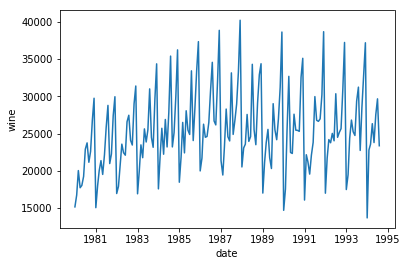

In [4]:
sns.lineplot(data['date'],data['wine'])

plt.show()

Попробуем поделить на число дней в месяце: 

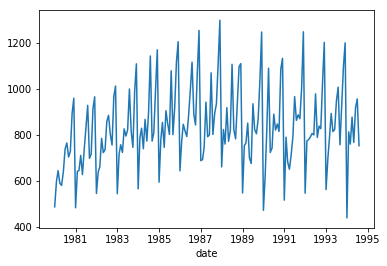

In [7]:
values = data['wine'].values.copy()
days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
for i in range(len(values)):
    values[i]/=days[i%12]
sns.lineplot(data['date'],values)

plt.show()

Ряд не стал более регулярным, так что вернёмся к исходным данным.

STL-декомпозиция ряда:

In [8]:
data = data.set_index(pd.DatetimeIndex(data['date']))

In [9]:
data.head()

,date,wine
date,,
1980-01-01,1980-01-01,15136
1980-02-01,1980-02-01,16733
1980-03-01,1980-03-01,20016
1980-04-01,1980-04-01,17708
1980-05-01,1980-05-01,18019


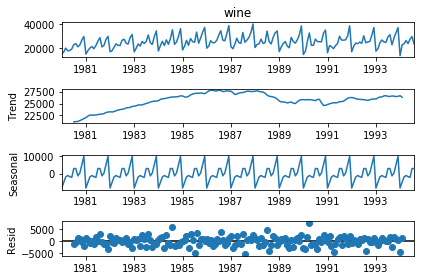

In [10]:
stl_data = seasonal_decompose(data['wine'])
_= stl_data.plot()

0.23667537162383442


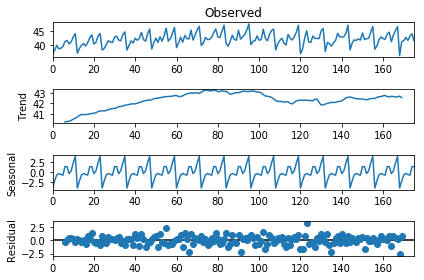

In [11]:
transformed, lam = st.boxcox(data['wine'])
data['bc'] = transformed
print (lam)
stl_data = seasonal_decompose(transformed, period=12)
_= stl_data.plot()

# ARIMA
Стационарность:

In [12]:
kpss(data['wine'], nlags='legacy')

(0.5448466202836393,
 0.03156607651269385,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Cделаем сезонное дифференцирование: 

(0.5200996002022095,
 0.03713972968418706,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

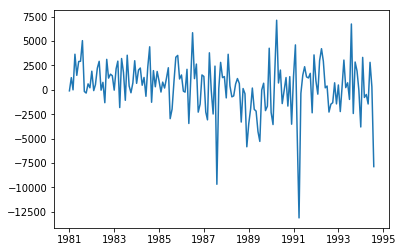

In [13]:
diff_ts = data['wine'].diff(12)[12:]
plt.plot(diff_ts)
kpss(diff_ts, nlags='legacy')

Ряд всё ещё нестационарен. Проведём ещё одно дифференцирование: 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.1466436817476703,
 0.1,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

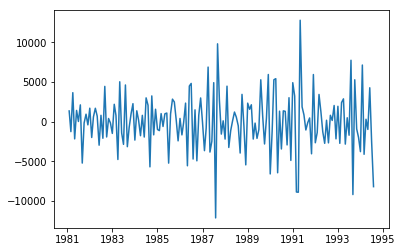

In [14]:
diff_diff_ts = diff_ts.diff(1)[1:]
plt.plot(diff_diff_ts)
kpss(diff_diff_ts, nlags='legacy')

Для полученного ряда гипотеза стационарности не отвергается

Посмотрим на ACF и PACF полученного продифференцированного ряда:

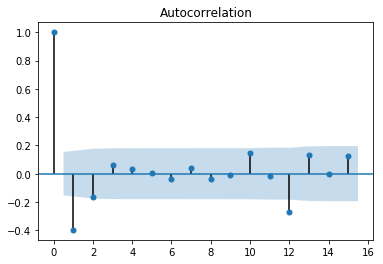

In [15]:
plot_acf(diff_diff_ts, lags=15)

plt.show()

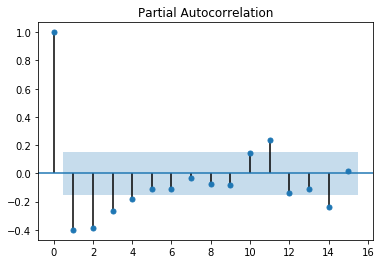

In [16]:
plot_pacf(diff_diff_ts, lags=15)

plt.show()

На ACF значимы лаги 1 и 12, на PACF — 1-3. Будем искать модель, оптимальную по AICc, в окрестности ARIMA(3,1,1)

In [17]:
for i in range(-1,2):
    for k in range(-1, 2):
        order = (3+i,1,1+k)
        try:
            arima = ARIMA(data['wine'].values, order=order).fit()
            print(arima.summary())
        except:
            pass 

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  175
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1764.553
Method:                       css-mle   S.D. of innovations           5783.214
Date:                Tue, 21 Apr 2020   AIC                           3537.107
Time:                        18:32:59   BIC                           3549.766
Sample:                             1   HQIC                          3542.242
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.9051    234.100      0.226      0.821    -405.923     511.733
ar.L1.D.y     -0.4337      0.068     -6.399      0.000      -0.566      -0.301
ar.L2.D.y     -0.4413      0.067     -6.550      0.0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:672: RuntimeWarning: invalid value encountered in arctanh
  invarcoefs = 2*np.arctanh(params)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  175
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1749.878
Method:                       css-mle   S.D. of innovations           5310.240
Date:                Tue, 21 Apr 2020   AIC                           3511.757
Time:                        18:33:00   BIC                           3530.745
Sample:                             1   HQIC                          3519.459
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.8815    141.359      0.360      0.719    -226.177     327.940
ar.L1.D.y     -0.6435      0.075     -8.547      0.000      -0.791      -0.496
ar.L2.D.y     -0.6711      0.083     -8.114      0.0

In [18]:
arima = ARIMA(data['wine'].values, order=(2,1,1)).fit()
print(arima.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  175
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1739.339
Method:                       css-mle   S.D. of innovations           4980.096
Date:                Tue, 21 Apr 2020   AIC                           3488.678
Time:                        18:33:40   BIC                           3504.502
Sample:                             1   HQIC                          3495.097
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.1274     24.556      1.268      0.205     -17.001      79.255
ar.L1.D.y      0.1196      0.075      1.596      0.110      -0.027       0.267
ar.L2.D.y     -0.2752      0.074     -3.700      0.0

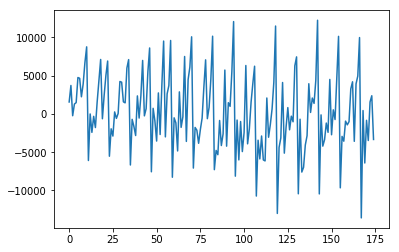

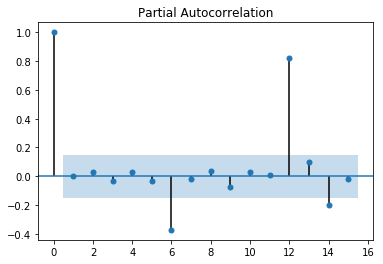

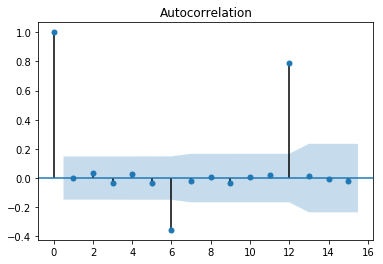

In [19]:
plt.plot(arima.resid)
plot_pacf(arima.resid, lags=15)
plot_acf(arima.resid, lags=15)

plt.show()

In [20]:
for i in range(-1,2):
    for j in range(-1, 2):
        order = (3+i, 1, 1+j)
        sorder = (1, 1, 1, 12)
        try:
            arima = SARIMAX(data['wine'].values, order=order, seasonal_order=sorder).fit()
            print(arima.summary())
        except:
            pass 

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  176
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -1532.390
Date:                              Tue, 21 Apr 2020   AIC                           3074.781
Time:                                      18:34:22   BIC                           3090.249
Sample:                                           0   HQIC                          3081.061
                                              - 176                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4661      0.041    -11.448      0.000      -0.546      -0.386
ar.L2         -0.29

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  176
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1527.899
Date:                            Tue, 21 Apr 2020   AIC                           3069.798
Time:                                    18:34:24   BIC                           3091.454
Sample:                                         0   HQIC                          3078.590
                                            - 176                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0949      0.253      0.375      0.707      -0.401       0.591
ar.L2         -0.0903      0.133   

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  176
Model:             SARIMAX(3, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1527.611
Date:                              Tue, 21 Apr 2020   AIC                           3071.221
Time:                                      18:34:26   BIC                           3095.971
Sample:                                           0   HQIC                          3081.269
                                              - 176                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5571      1.984     -0.281      0.779      -4.445       3.331
ar.L2         -0.05

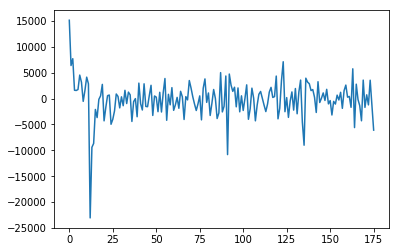

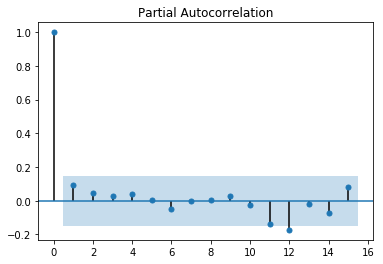

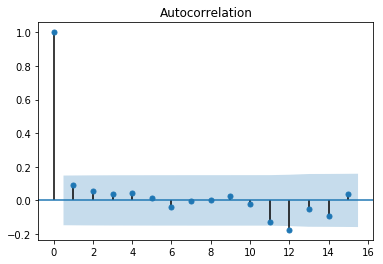

In [21]:
arima = SARIMAX(data['wine'].values, order=(2,1,1), seasonal_order=(1, 1, 1, 12)).fit()


plt.plot(arima.resid)
plot_pacf(arima.resid, lags=15)
plot_acf(arima.resid, lags=15)

plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


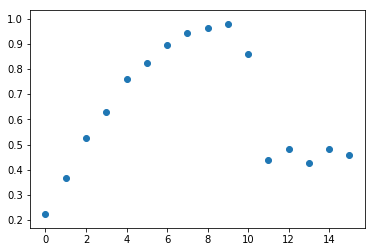

In [22]:
plt.scatter(range(16), acorr_ljungbox(arima.resid, lags=16)[1])

plt.show()

Q-Q plot: 

(0.8828683495521545, 1.630462986845771e-10)


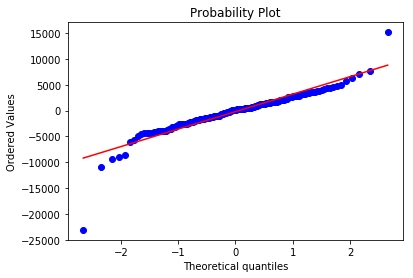

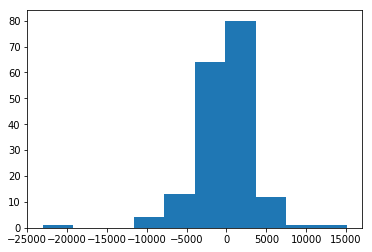

In [23]:
_ = st.probplot(arima.resid, plot=plt)
print (st.shapiro(arima.resid))
plt.show()
plt.hist(arima.resid)

plt.show()

In [30]:
arima = SARIMAX(data['wine'].values[:-12], order=(2,1,1), seasonal_order=(1,1,1,12)).fit()
predicted = arima.predict(0, data.shape[0])

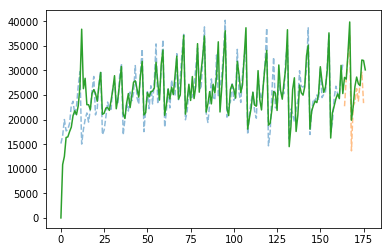

In [31]:
plt.plot(data['wine'].values[:-12], alpha=0.5, ls='--')
plt.plot(range(len(data['wine'].values[:-12]), len(data['wine'])), data['wine'].values[-12:], alpha=0.5, ls='--')
plt.plot(predicted)

plt.show()

In [51]:
arima = SARIMAX(data['wine'].values[:-12], order=(2,1,1), seasonal_order=(1,1,1,12)).fit()
predicted = arima.predict(data.shape[0]-12, data.shape[0]-1, dynamic=True)

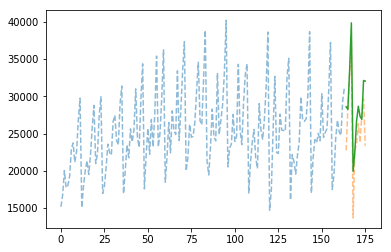

In [52]:
plt.plot(data['wine'].values[:-12], alpha=0.5, ls='--')
plt.plot(range(len(data['wine'].values[:-12]), len(data['wine'])), data['wine'].values[-12:], alpha=0.5, ls='--')
plt.plot(range(len(data['wine'].values[:-12]), len(data['wine'])), predicted)

plt.show()

# Прогноз ETS

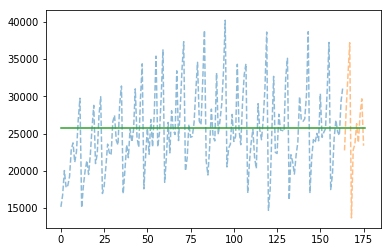

In [53]:
ets = ExponentialSmoothing(data['wine'].values[12:]).fit(optimized=True)

predicted = ets.predict(0, data.shape[0])

plt.plot(data['wine'].values[:-12], alpha=0.5, ls='--')
plt.plot(range(len(data['wine'].values[:-12]), len(data['wine'])), data['wine'].values[-12:], alpha=0.5, ls='--')
plt.plot(predicted)

plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


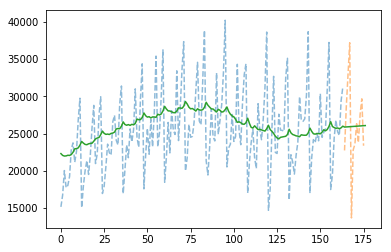

In [54]:
ets = ExponentialSmoothing(data['wine'].values[12:], trend='add').fit()

predicted = ets.predict(0, data.shape[0])

plt.plot(data['wine'].values[:-12], alpha=0.5, ls='--')
plt.plot(range(len(data['wine'].values[:-12]), len(data['wine'])), data['wine'].values[-12:], alpha=0.5, ls='--')
plt.plot(predicted)

plt.show()

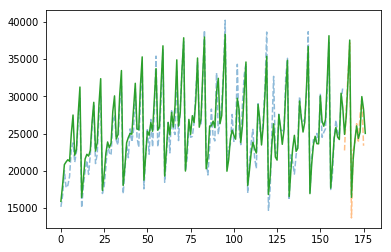

In [55]:
ets = ExponentialSmoothing(data['wine'].values[12:], seasonal='mul', trend='add', seasonal_periods=12).fit()

predicted = ets.predict(0, data.shape[0])

plt.plot(data['wine'].values[:-12], alpha=0.5, ls='--')
plt.plot(range(len(data['wine'].values[:-12]), len(data['wine'])), data['wine'].values[-12:], alpha=0.5, ls='--')
plt.plot(predicted)

plt.show()

(0.9575194716453552, 6.833939551142976e-05)


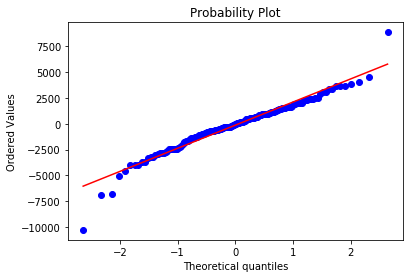

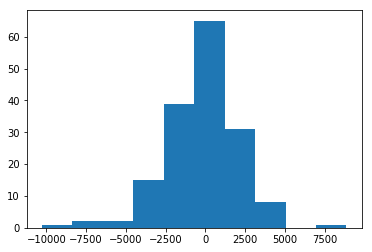

In [56]:
_ = st.probplot(ets.resid, plot=plt)
print (st.shapiro(ets.resid))
plt.show()

plt.hist(ets.resid)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


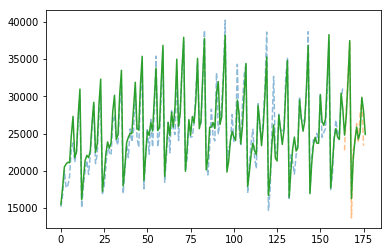

In [57]:
ets = ExponentialSmoothing(data['wine'].values[12:], seasonal='mul', trend='add', seasonal_periods=12).fit(use_boxcox=True)

predicted = ets.predict(0, data.shape[0])

plt.plot(data['wine'].values[:-12], alpha=0.5, ls='--')
plt.plot(range(len(data['wine'].values[:-12]), len(data['wine'])), data['wine'].values[-12:], alpha=0.5, ls='--')
plt.plot(predicted)

plt.show()

(0.957351565361023, 6.589614349650219e-05)


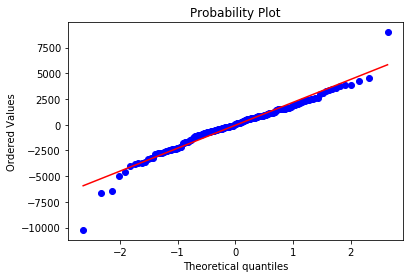

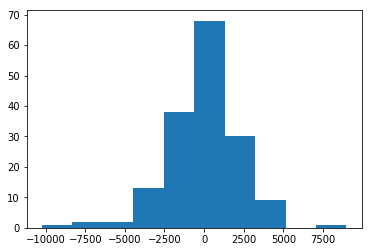

In [58]:
_ = st.probplot(ets.resid, plot=plt)
print (st.shapiro(ets.resid))
plt.show()

plt.hist(ets.resid)
plt.show()

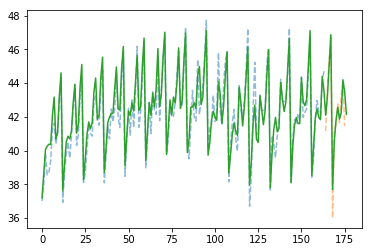

In [59]:
ets = ExponentialSmoothing(data['bc'].values[12:], seasonal='mul', trend='add', seasonal_periods=12).fit()

predicted = ets.predict(0, data.shape[0])

plt.plot(data['bc'].values[:-12], alpha=0.5, ls='--')
plt.plot(range(len(data['bc'].values[:-12]), len(data['bc'])), data['bc'].values[-12:], alpha=0.5, ls='--')
plt.plot(predicted)

plt.show()

(0.9607381224632263, 0.00013918183685746044)


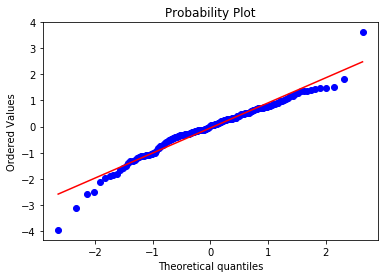

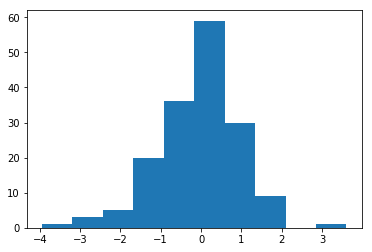

In [60]:
_ = st.probplot(ets.resid, plot=plt)
print (st.shapiro(ets.resid))
plt.show()

plt.hist(ets.resid)
plt.show()